In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from mordred import Calculator, descriptors
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot
from sklearn.cluster import SpectralClustering

In [44]:
df = pd.read_csv("data_compound.csv")
df

,sid,cid,smiles,bioactivity,type,value (nM)
0,316936247,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
1,316936247,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
2,374307293,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
3,336864381,127024762,C[C@@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C...,Active,IC50,1570.0
4,336858757,127024157,C[C@@H]1C[C@H]1NC2=NC3=CN=NC=C3N=C2N4CCC(CC4)[...,Active,IC50,145.0
...,...,...,...,...,...,...
834,316936296,118159205,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,49300.0
835,316936248,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
836,316936248,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
837,316936245,118159305,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Inactive,IC50,163000.0


In [45]:
df_hist = df[['cid','smiles','bioactivity', 'type', 'value (nM)']]
#df_hist = df_hist[df_hist["bioactivity"] != 'Unspecified']
df_hist

,cid,smiles,bioactivity,type,value (nM)
0,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
1,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
2,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
3,127024762,C[C@@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C...,Active,IC50,1570.0
4,127024157,C[C@@H]1C[C@H]1NC2=NC3=CN=NC=C3N=C2N4CCC(CC4)[...,Active,IC50,145.0
...,...,...,...,...,...
834,118159205,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,49300.0
835,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
836,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
837,118159305,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Inactive,IC50,163000.0


In [46]:
IC50_only = df_hist[df_hist['type']=='IC50'].reset_index(drop=True)
IC50_only['pIC50'] = 9 - np.log10(IC50_only['value (nM)'])
IC50_only = IC50_only.drop_duplicates(keep='first', ignore_index=True)
IC50_only

,cid,smiles,bioactivity,type,value (nM),pIC50
0,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0,5.080922
1,127024762,C[C@@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C...,Active,IC50,1570.0,5.804100
2,127024157,C[C@@H]1C[C@H]1NC2=NC3=CN=NC=C3N=C2N4CCC(CC4)[...,Active,IC50,145.0,6.838632
3,118159182,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,6600.0,5.180456
4,155525744,C[C@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C(...,Active,IC50,1570.0,5.804100
...,...,...,...,...,...,...
437,118159306,CN1CCC2=C(C1)N=C(C(=N2)NC3CC3)N4CCC(CC4)OC5=C(...,Inactive,IC50,145000.0,3.838632
438,118159408,COCC(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(CC...,Inactive,IC50,79500.0,4.099633
439,118159205,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,49300.0,4.307153
440,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0,4.242604


<Figure size 2000x2000 with 0 Axes>

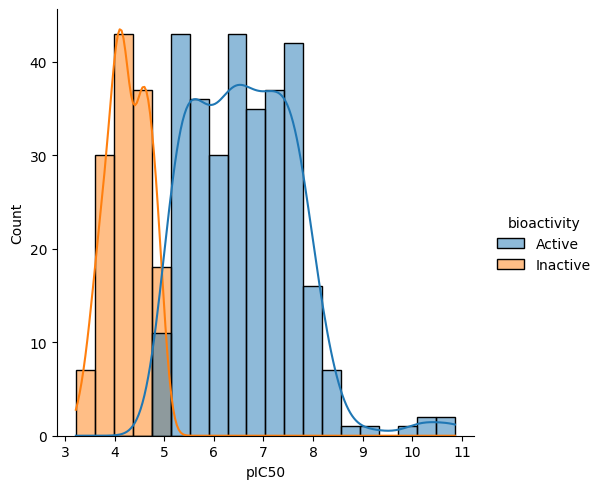

In [47]:
plt.figure(figsize=(20, 20))

sns.displot(IC50_only, bins=20, x='pIC50', hue='bioactivity', kde=True)
plt.show()

In [48]:
def canonical_smiles(smiles):
    mol_smiles = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mol_smiles]

    return smiles

In [49]:
CANNO_SMILES = canonical_smiles(IC50_only.smiles)
len(CANNO_SMILES)

442

In [50]:
IC50_only['smiles'] = CANNO_SMILES
IC50_only

,cid,smiles,bioactivity,type,value (nM),pIC50
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,8300.0,5.080922
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,Active,IC50,1570.0,5.804100
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,Active,IC50,145.0,6.838632
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,6600.0,5.180456
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,Active,IC50,1570.0,5.804100
...,...,...,...,...,...,...
437,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,Inactive,IC50,145000.0,3.838632
438,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,Inactive,IC50,79500.0,4.099633
439,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,Inactive,IC50,49300.0,4.307153
440,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,Inactive,IC50,57200.0,4.242604


Morgan Fingerprint

In [51]:
compounds_morgan = []

for _, smiles, bioactivity, pIC50 in IC50_only[['smiles', 'bioactivity', 'pIC50']].itertuples():
    compounds_morgan.append((Chem.MolFromSmiles(smiles), bioactivity, pIC50))
compounds_morgan[:5]

[(<rdkit.Chem.rdchem.Mol at 0x201abda3060>, 'Active', 5.080921907623926),
 (<rdkit.Chem.rdchem.Mol at 0x201abda3ca0>, 'Active', 5.804100347590767),
 (<rdkit.Chem.rdchem.Mol at 0x201abda3f40>, 'Active', 6.838631997765026),
 (<rdkit.Chem.rdchem.Mol at 0x201abda2ea0>, 'Active', 5.180456064458131),
 (<rdkit.Chem.rdchem.Mol at 0x201abda2dc0>, 'Active', 5.804100347590767)]

In [52]:
compounds_morgan_structure = pd.DataFrame(compounds_morgan, columns=["Structure", "bioactivity", "pIC50"])
compounds_morgan_structure.head(5)

,Structure,bioactivity,pIC50
0,<rdkit.Chem.rdchem.Mol object at 0x00000201ABD...,Active,5.080922
1,<rdkit.Chem.rdchem.Mol object at 0x00000201ABD...,Active,5.804100
2,<rdkit.Chem.rdchem.Mol object at 0x00000201ABD...,Active,6.838632
3,<rdkit.Chem.rdchem.Mol object at 0x00000201ABD...,Active,5.180456
4,<rdkit.Chem.rdchem.Mol object at 0x00000201ABD...,Active,5.804100


In [53]:
def generate_mfpts(data):
    Mfpts = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in data]
    return Mfpts

mfpts = generate_mfpts(compounds_morgan_structure.Structure[:])
print("Number of compounds converted:", len(mfpts))
print("Fingerprint length per compound:", len(mfpts[0]))

Number of compounds converted: 442
Fingerprint length per compound: 2048


In [54]:
fp_name_morgan = [f'Bit_{i}' for i in range(2048)]
fp_bits_morgan = [list(l) for l in mfpts]

morganfp_df = pd.DataFrame(fp_bits_morgan, index=IC50_only["bioactivity"], columns=fp_name_morgan)
morganfp_df.reset_index(inplace=True)  # Reset index to bring "cid" back as a column
morganfp_df.rename(columns={"index": "bioactivity"})# Rename the index column to "cid"
morganfp_df.head()

,bioactivity,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
morganfp_df_umap = morganfp_df.iloc[:, 1:]
morganfp_df_umap

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
438,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


RDK5 Fingerprint

In [56]:
compounds_rdk5 = []

for _, smiles, bioactivity in IC50_only[['smiles', 'bioactivity']].itertuples():
    compounds_rdk5.append((Chem.MolFromSmiles(smiles), bioactivity))
compounds_rdk5[:5]

[(<rdkit.Chem.rdchem.Mol at 0x201a6164660>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x201a61644a0>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x201a61647b0>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x201a6164b30>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x201a6164f20>, 'Active')]

In [57]:
compound_rdk5_structure = pd.DataFrame(compounds_rdk5, columns=["Structure", "bioactivity"])
compound_rdk5_structure

,Structure,bioactivity
0,<rdkit.Chem.rdchem.Mol object at 0x00000201A61...,Active
1,<rdkit.Chem.rdchem.Mol object at 0x00000201A61...,Active
2,<rdkit.Chem.rdchem.Mol object at 0x00000201A61...,Active
3,<rdkit.Chem.rdchem.Mol object at 0x00000201A61...,Active
4,<rdkit.Chem.rdchem.Mol object at 0x00000201A61...,Active
...,...,...
437,<rdkit.Chem.rdchem.Mol object at 0x00000201ADF...,Inactive
438,<rdkit.Chem.rdchem.Mol object at 0x00000201ADF...,Inactive
439,<rdkit.Chem.rdchem.Mol object at 0x00000201ADF...,Inactive
440,<rdkit.Chem.rdchem.Mol object at 0x00000201ADF...,Inactive


In [58]:
def generate_rdk5(data):
    rdk5_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    rdk5_fingerprint = [rdk5_gen.GetFingerprint(mol) for mol in data]
    return rdk5_fingerprint

rdk5fp = generate_rdk5(compound_rdk5_structure.Structure[:])
print("Number of compounds converted:", len(rdk5fp))
print("Fingerprint length per compound:", len(rdk5fp[0]))

Number of compounds converted: 442
Fingerprint length per compound: 2048


In [59]:
fp_name_rdk5 = [f'Bit_{i}' for i in range(2048)]
fp_bits_rdk5 = [list(l) for l in rdk5fp]

rdk5_df = pd.DataFrame(fp_bits_rdk5, index=IC50_only["bioactivity"], columns=fp_name_rdk5)
rdk5_df.reset_index(inplace=True)  # Reset index to bring "cid" back as a column
rdk5_df.rename(columns={"index": "bioactivity"})# Rename the index column to "cid"
rdk5_df.head()

,bioactivity,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,Active,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [60]:
rdk5_df_umap = rdk5_df.iloc[:, 1:]
rdk5_df_umap

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
438,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
439,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
440,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


 UMAP Morgan Fingerprint

In [127]:
umapper = umap.UMAP(n_neighbors=20, 
                    n_components=2,
                    metric='euclidean', 
                    random_state=5
                    )

In [128]:
data_umap_morgan = umapper.fit_transform(morganfp_df_umap)


In [129]:
data_umap_morgan_x = pd.DataFrame(data_umap_morgan[:, 0], columns = ['x'])
data_umap_morgan_y = pd.DataFrame(data_umap_morgan[:, 1], columns = ['y'])
bioactivity = pd.DataFrame(morganfp_df["bioactivity"].values, columns = ['bioactivity'])
plot_umap_morgan = pd.concat([bioactivity, data_umap_morgan_x, data_umap_morgan_y], axis = 1)
plot_umap_morgan

,bioactivity,x,y
0,Active,16.450281,-1.394709
1,Active,4.569525,-2.437729
2,Active,7.558885,2.017514
3,Active,16.383541,-1.362142
4,Active,4.543643,-2.369316
...,...,...,...
437,Inactive,16.447542,0.453163
438,Inactive,16.204445,-1.075147
439,Inactive,16.788517,-0.324396
440,Inactive,16.917850,-0.536659


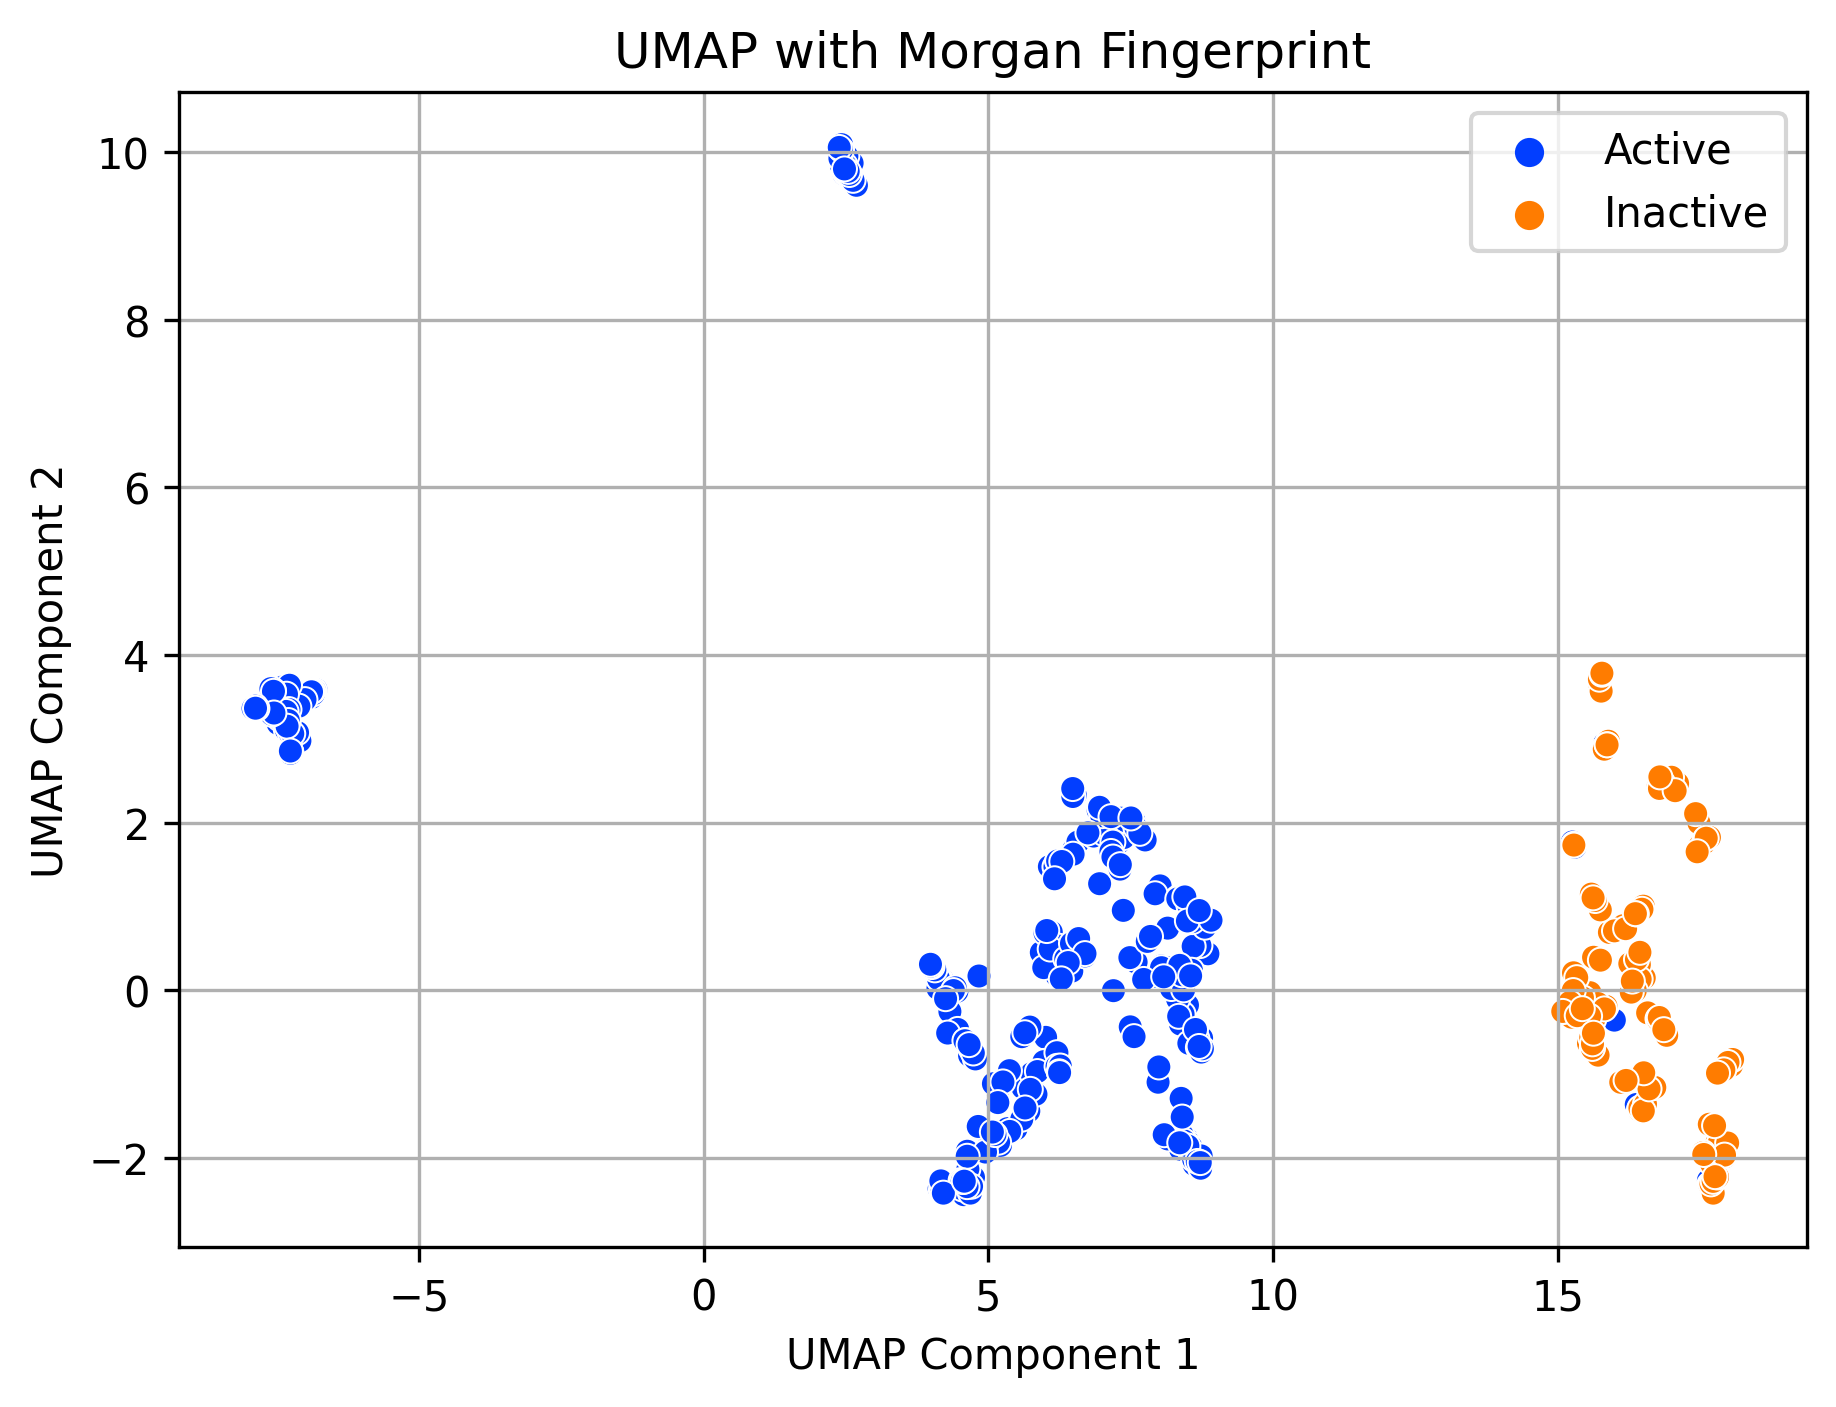

In [130]:
plt.figure(figsize = (7, 5), dpi=300)
sns.scatterplot(x='x', y='y', hue='bioactivity', data=plot_umap_morgan, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP with Morgan Fingerprint', fontsize=12)
plt.show()

UMAP with RDK5 Fingerprint

In [158]:
umapper = umap.UMAP(n_neighbors=50, 
                    n_components=2,
                    metric='euclidean', 
                    random_state=42,
                    )

In [159]:
data_umap_rdk5 = umapper.fit_transform(rdk5_df_umap)

In [160]:
data_umap_rdk5_x = pd.DataFrame(data_umap_rdk5[:, 0], columns = ['x'])
data_umap_rdk5_y = pd.DataFrame(data_umap_rdk5[:, 1], columns = ['y'])
bioactivity = pd.DataFrame(rdk5_df["bioactivity"].values, columns = ['bioactivity'])
plot_umap_rdk5 = pd.concat([bioactivity, data_umap_rdk5_x, data_umap_rdk5_y], axis = 1)
plot_umap_rdk5

,bioactivity,x,y
0,Active,-0.520080,15.868576
1,Active,-1.177173,-7.051076
2,Active,-7.468177,3.669787
3,Active,-0.597130,15.842898
4,Active,-1.191095,-7.162016
...,...,...,...
437,Inactive,-1.834675,15.644149
438,Inactive,-0.556223,15.757682
439,Inactive,0.750193,14.220204
440,Inactive,0.714958,14.170947


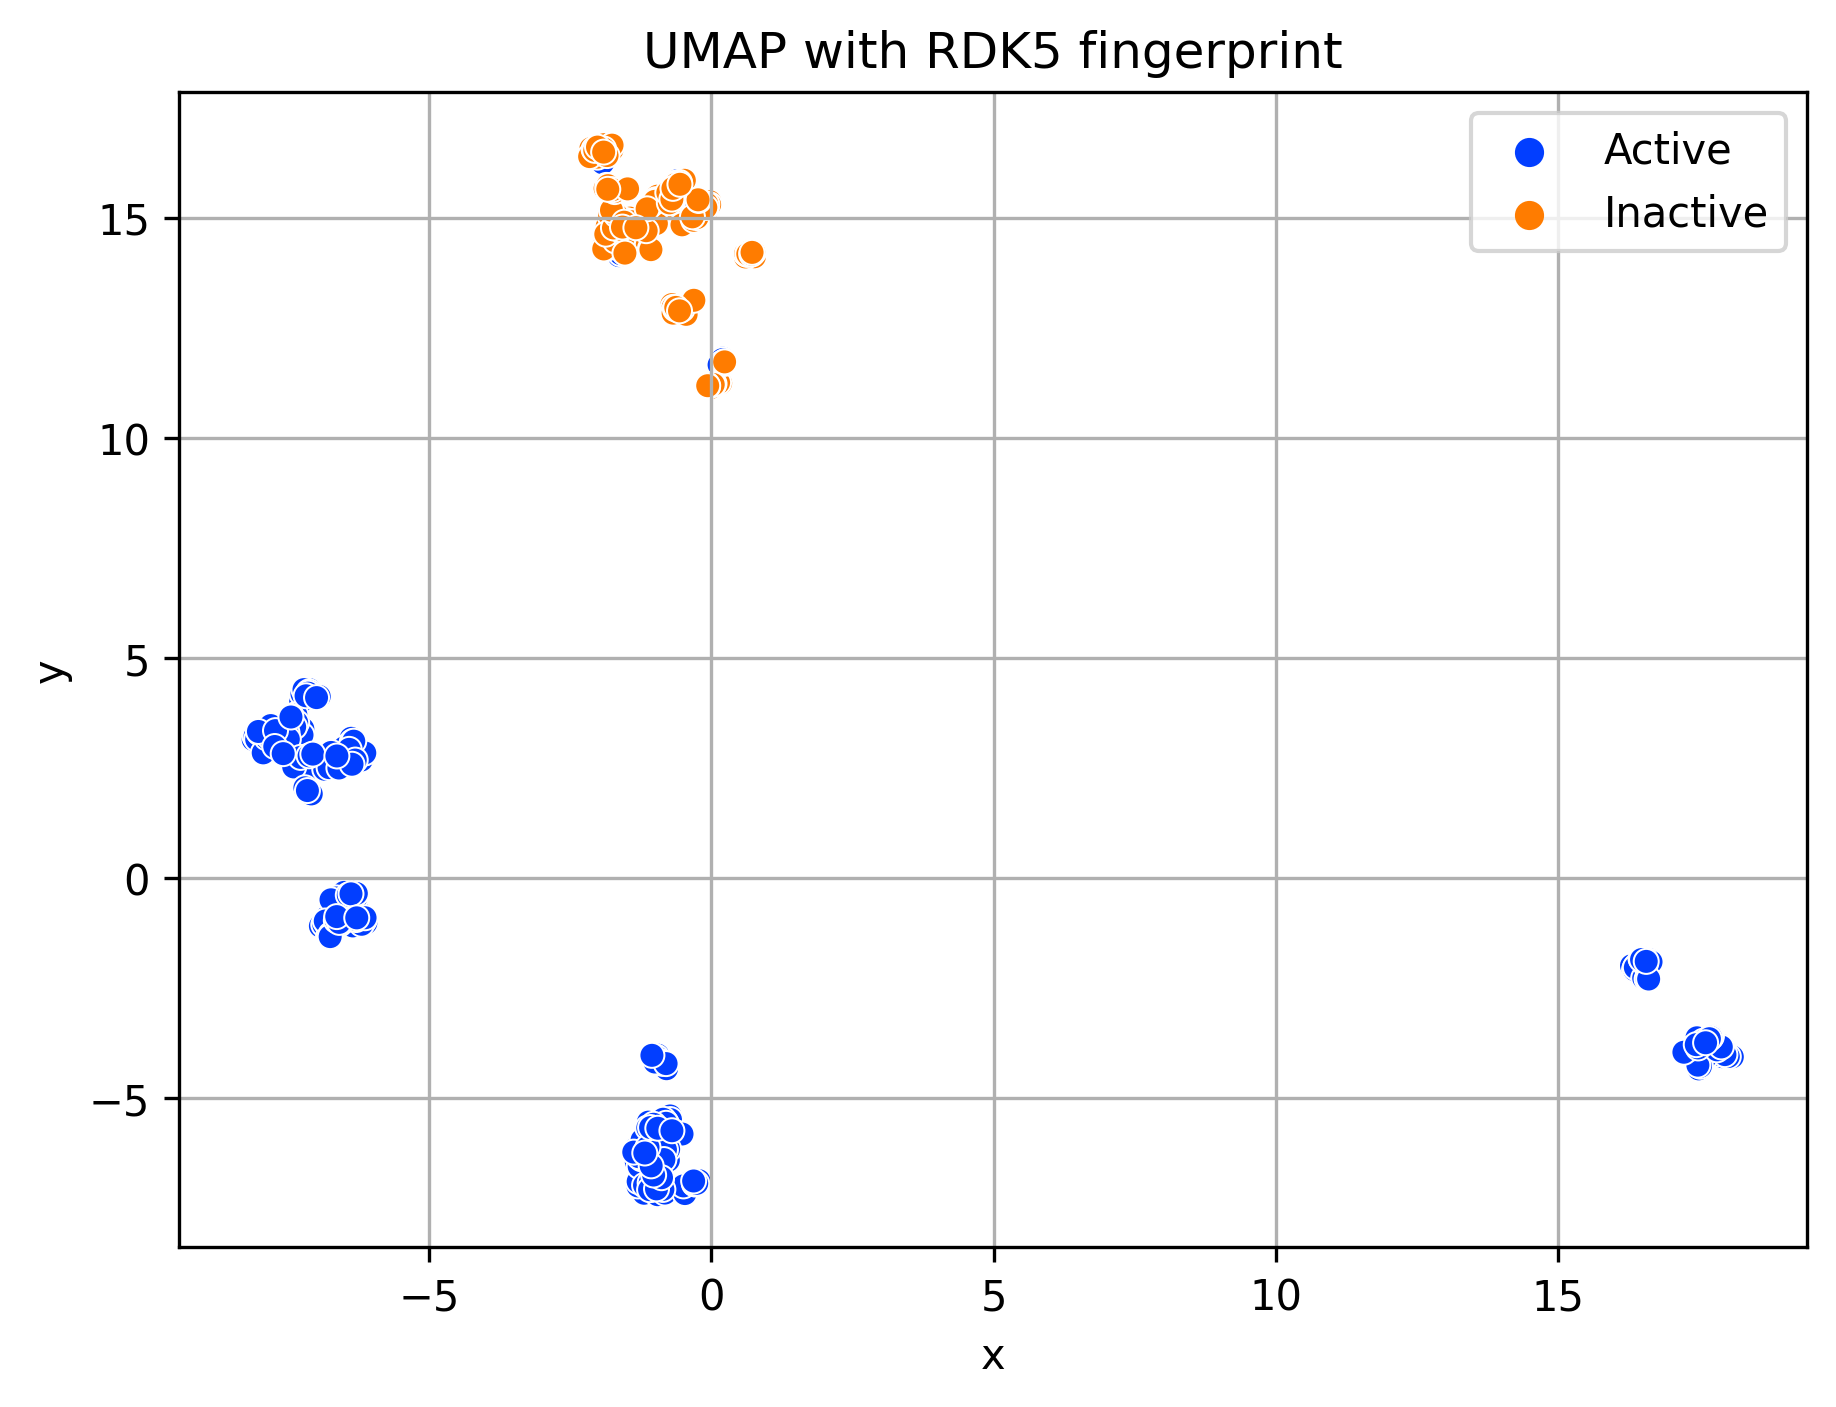

In [161]:
plt.figure(figsize = (7, 5), dpi=300)
sns.scatterplot(x='x', y='y', hue='bioactivity', data=plot_umap_rdk5, palette='bright')
plt.grid()
plt.legend()
plt.title('UMAP with RDK5 fingerprint', fontsize=12)
plt.show()

Clustering by Butina of Morgan FP

In [163]:
from rdkit.ML.Cluster import Butina

In [164]:
def tanimoto_distance_matrix(fp_list):
    
    dissimilarity_matrix = []
    
    for i in range(1, len(fp_list)):
        
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [165]:
sim = DataStructs.TanimotoSimilarity(mfpts[0], mfpts[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.24, distance: 0.76


In [166]:
tanimoto_distance_matrix(mfpts)

[0.7572815533980582,
 0.6734693877551021,
 0.6808510638297872,
 0.0,
 0.7572815533980582,
 0.6734693877551021,
 0.7572815533980582,
 0.0,
 0.6808510638297872,
 0.7572815533980582,
 0.7821782178217822,
 0.7,
 0.7340425531914894,
 0.7821782178217822,
 0.7,
 0.5813953488372092,
 0.7916666666666666,
 0.611764705882353,
 0.5813953488372092,
 0.7916666666666666,
 0.6463414634146342,
 0.7647058823529411,
 0.2857142857142857,
 0.6739130434782609,
 0.7647058823529411,
 0.2857142857142857,
 0.6627906976744187,
 0.7608695652173914,
 0.7264150943396226,
 0.6276595744680851,
 0.6063829787234043,
 0.7264150943396226,
 0.6276595744680851,
 0.6521739130434783,
 0.6333333333333333,
 0.5888888888888889,
 0.7037037037037037,
 0.7358490566037736,
 0.4367816091954023,
 0.7037037037037037,
 0.7358490566037736,
 0.696969696969697,
 0.6086956521739131,
 0.7184466019417476,
 0.4838709677419355,
 0.7037037037037037,
 0.7358490566037736,
 0.4367816091954023,
 0.7037037037037037,
 0.7358490566037736,
 0.696969696

In [167]:
n = len(mfpts)

elem_triangular_matr = (n * (n - 1)) / 2

print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(mfpts) ({len(tanimoto_distance_matrix(mfpts))})",
)

Elements in the triangular matrix (97461) == tanimoto_distance_matrix(mfpts) (97461)


In [168]:
def cluster_mfpts(fingerprints, cutoff=0.3):

    distance_matrix = tanimoto_distance_matrix(mfpts)
    clusters = Butina.ClusterData(distance_matrix, len(mfpts), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

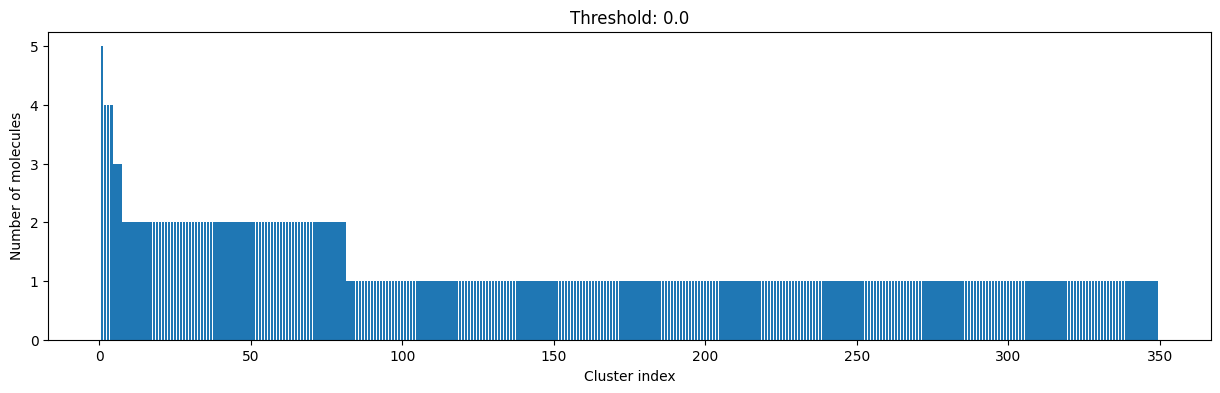

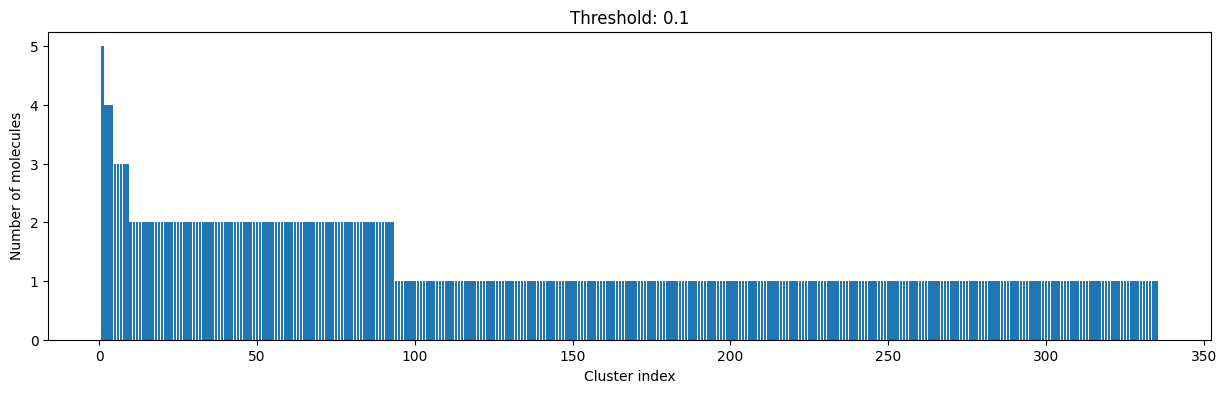

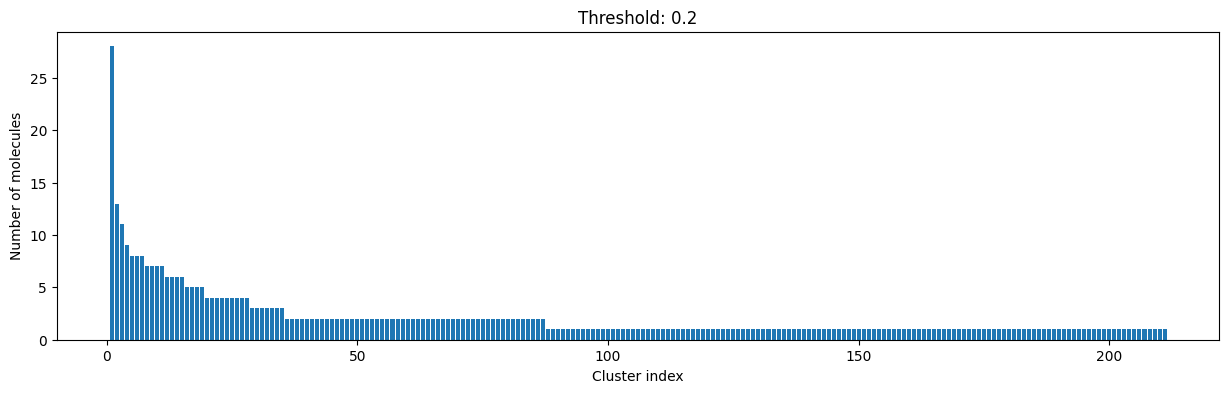

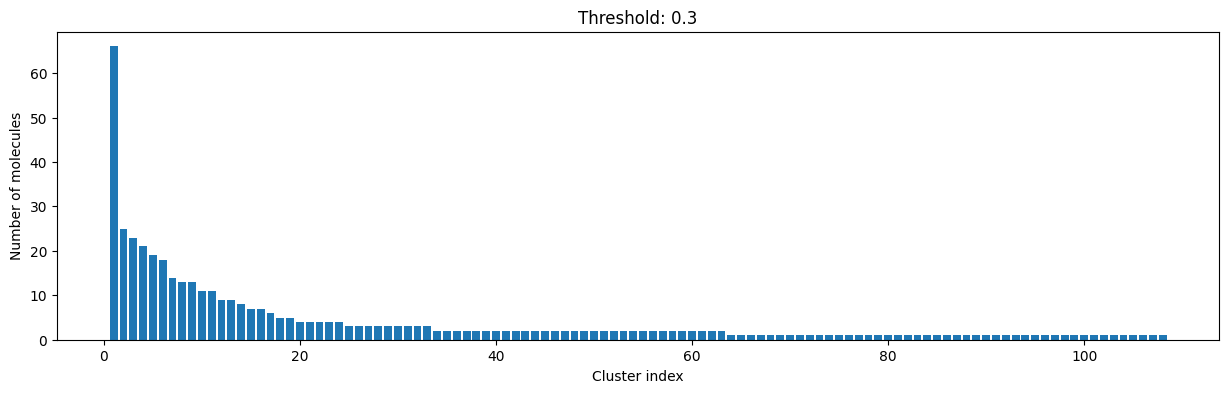

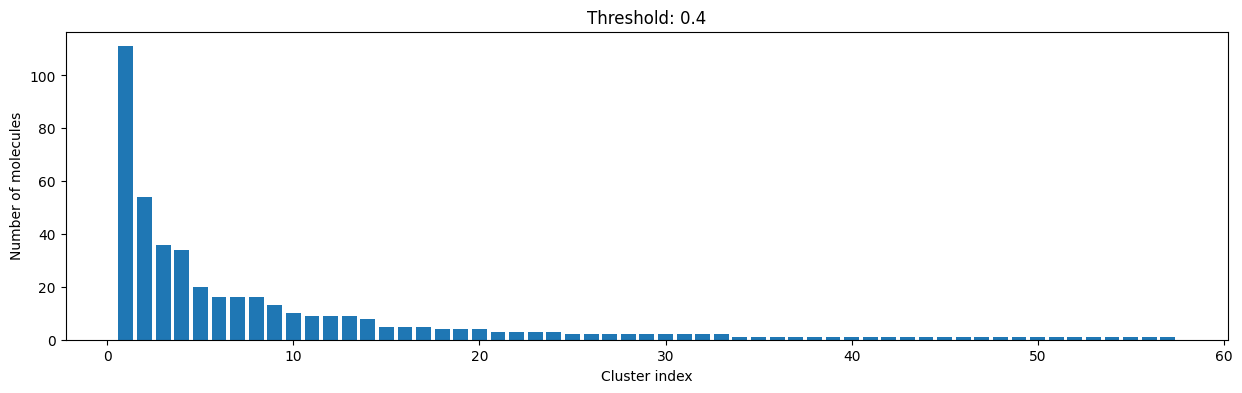

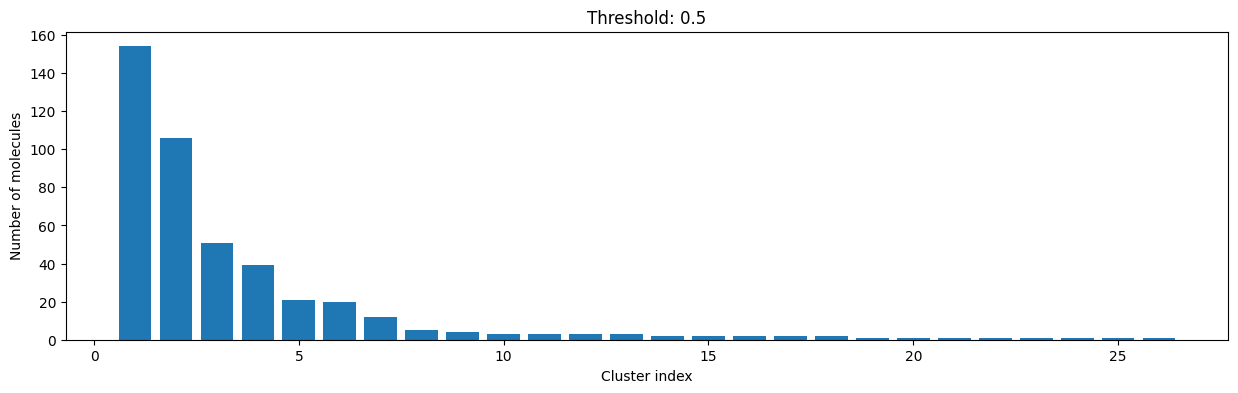

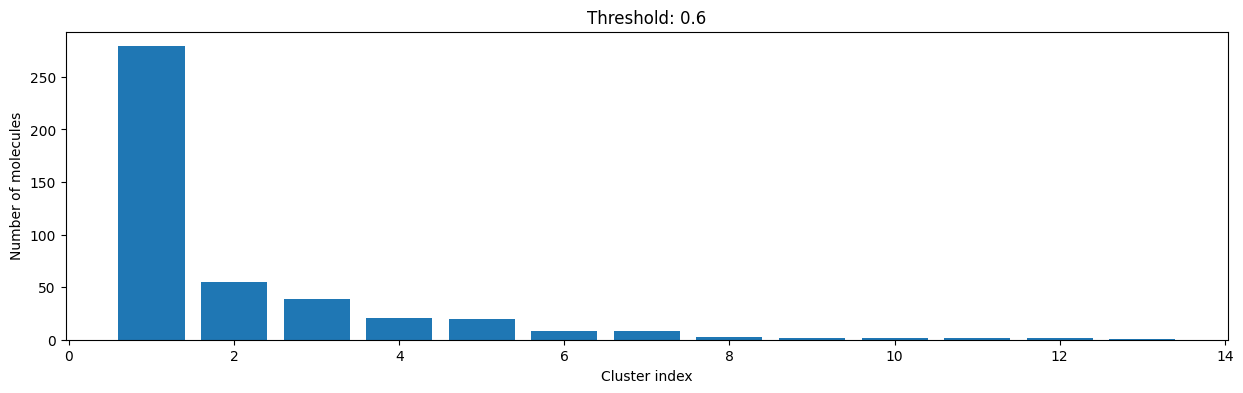

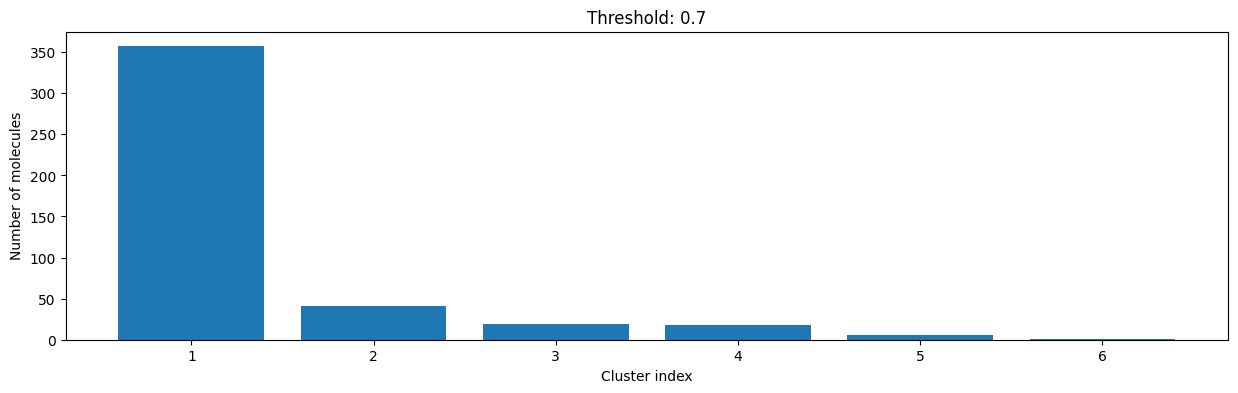

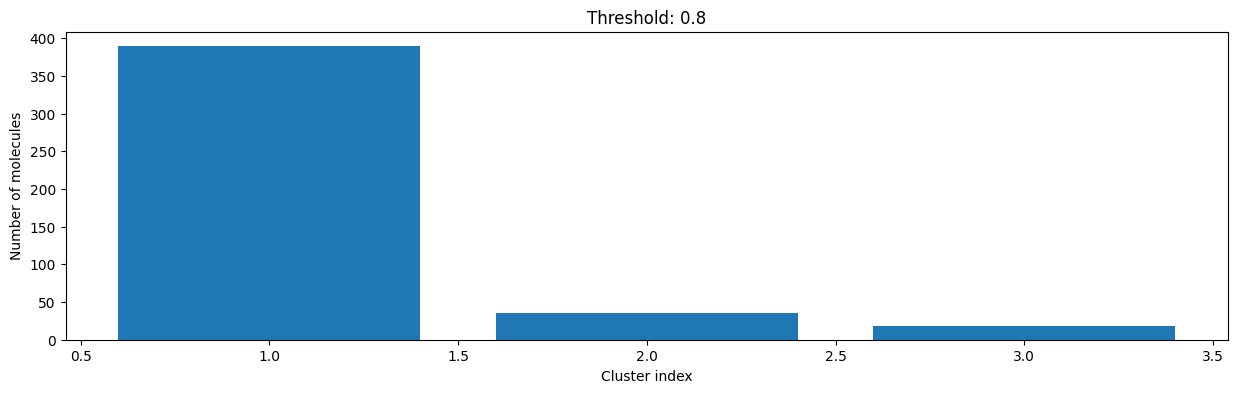

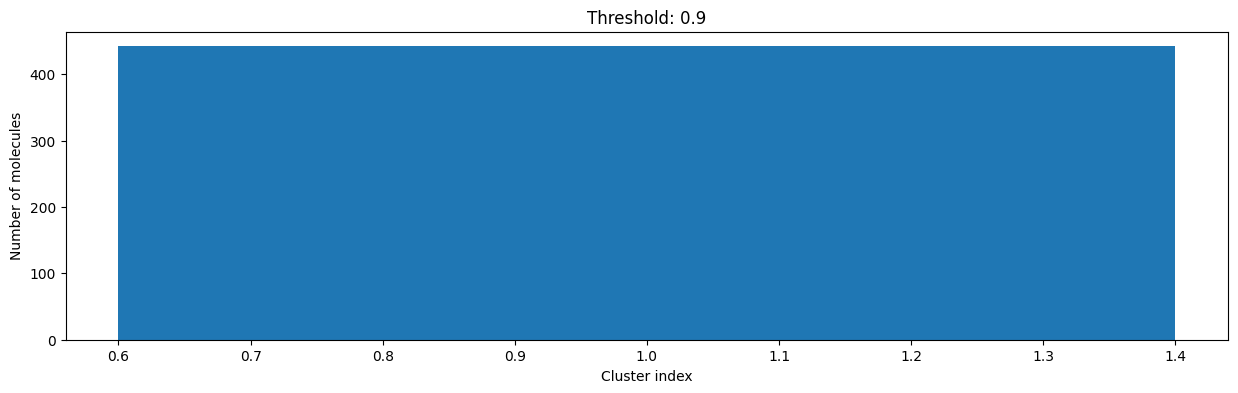

In [169]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = cluster_mfpts(mfpts, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    plt.show()

In [170]:
from sklearn.decomposition import PCA

In [171]:
data_umap_morgan

array([[ 1.64502811e+01, -1.39470875e+00],
       [ 4.56952524e+00, -2.43772864e+00],
       [ 7.55888462e+00,  2.01751423e+00],
       [ 1.63835411e+01, -1.36214161e+00],
       [ 4.54364252e+00, -2.36931586e+00],
       [ 4.44812918e+00, -1.21023096e-02],
       [ 8.49838257e+00, -1.77032694e-01],
       [ 4.73878479e+00, -2.23080277e+00],
       [ 6.00613880e+00, -5.61088562e-01],
       [ 7.31913233e+00,  1.76001108e+00],
       [ 7.30140686e+00,  1.76879466e+00],
       [ 7.90854597e+00,  1.66150093e-01],
       [ 5.08379698e+00, -1.68664670e+00],
       [ 6.50047445e+00,  1.67910945e+00],
       [ 6.57324123e+00,  1.76904178e+00],
       [ 5.93057013e+00,  4.51670527e-01],
       [ 4.83538294e+00,  1.70588151e-01],
       [ 7.59605503e+00,  3.36429834e-01],
       [ 4.82613420e+00, -1.60876644e+00],
       [ 5.58764458e+00, -5.53040206e-01],
       [ 3.98252344e+00,  3.11360568e-01],
       [ 4.00693417e+00,  2.81421483e-01],
       [ 4.11496592e+00,  2.26787198e-02],
       [ 4.

Plot Each Clusters by UMAP

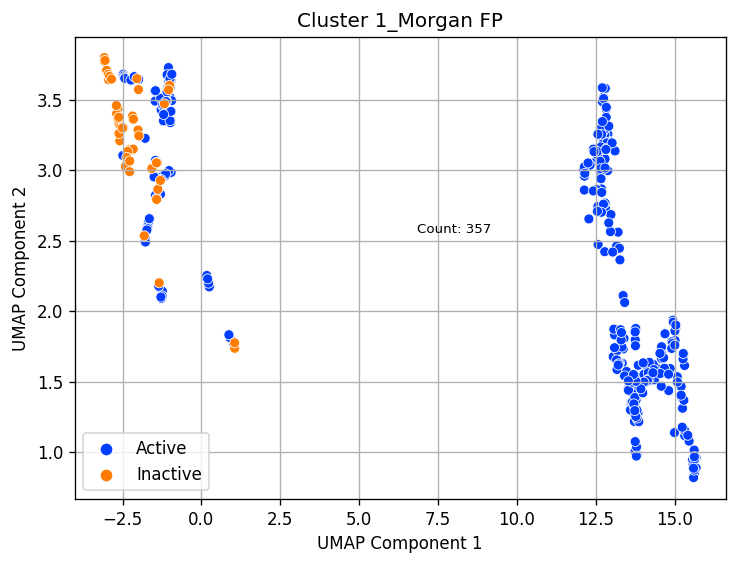

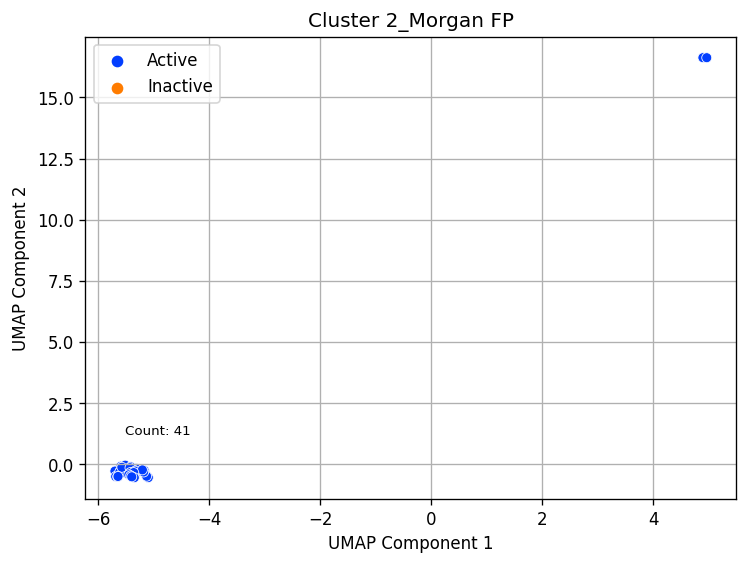

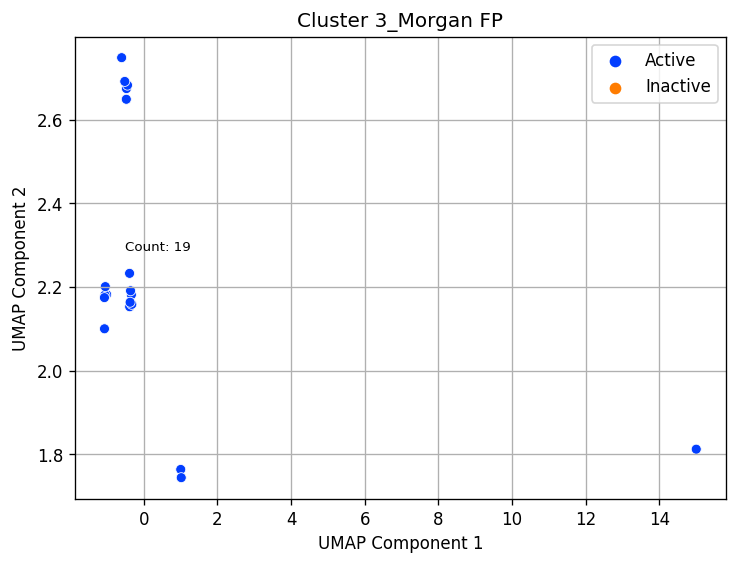

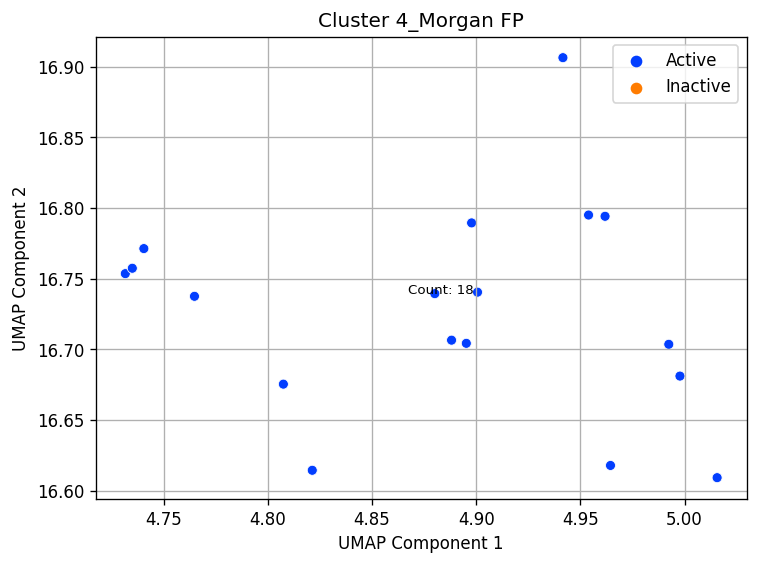

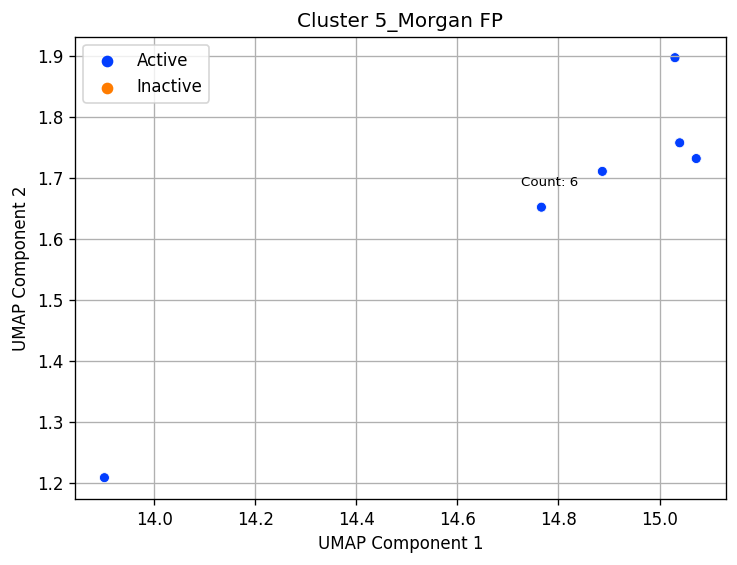

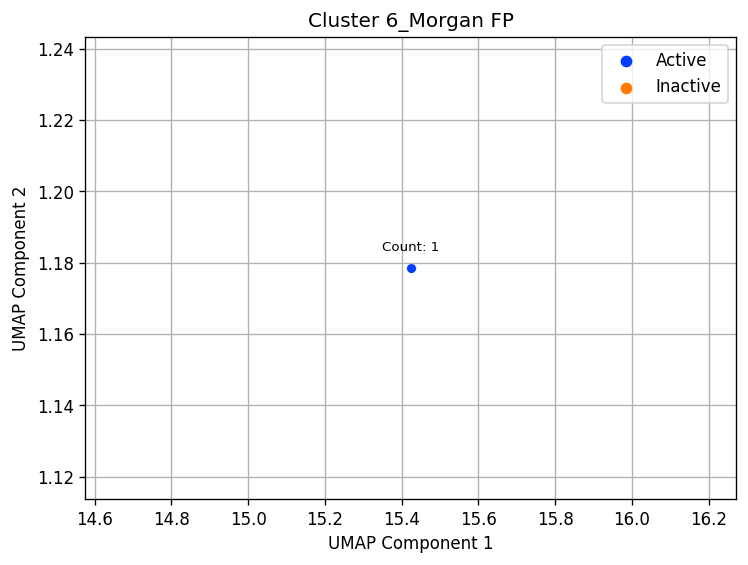

In [193]:
# Start with UMAP
umapper = umap.UMAP(n_neighbors=20, 
                    n_components=5,
                    metric='euclidean',
                    random_state=5
                    )

data_umap_morgan = umapper.fit_transform(morganfp_df_umap)

# Apply Butina functions
cutoff = 0.7
clusters = cluster_mfpts(data_umap_morgan, cutoff=cutoff)


# Create a scatter plot using Seaborn
for cluster_index, cluster in enumerate(clusters, start=1):
    cluster_molecule_indices = cluster 
    
    cluster_coords = data_umap_morgan[cluster_molecule_indices, :]
    
    x_coords = cluster_coords[:, 0]
    y_coords = cluster_coords[:, 1]
    
    cluster_labels = np.full(len(cluster_molecule_indices), f"Cluster {cluster_index}")
    
    
    data_umap_morgan_x = pd.DataFrame(x_coords, columns = ['x'])
    data_umap_morgan_y = pd.DataFrame(y_coords, columns = ['y'])
    bioactivity = pd.DataFrame(morganfp_df["bioactivity"].values, columns = ['bioactivity'])
    plot_umap_morgan_butina = pd.concat([bioactivity, data_umap_morgan_x, data_umap_morgan_y], axis = 1)
    plot_umap_morgan_butina
    
    plt.figure(figsize=(7, 5), dpi=120)
    sns.scatterplot(x="x", y="y", hue='bioactivity' , data=plot_umap_morgan_butina, palette='bright')
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.title(f"Cluster {cluster_index}_Morgan FP")
    
    cluster_size = len(cluster_molecule_indices)
    mean_x = np.mean(data_umap_morgan[cluster_molecule_indices, 0])
    mean_y = np.mean(data_umap_morgan[cluster_molecule_indices, 1])
    plt.annotate(f"Count: {cluster_size}", (mean_x, mean_y), xytext=(0, 10),textcoords="offset points", ha='center', fontsize=8)

    plt.legend()
    plt.grid()
    plt.show()

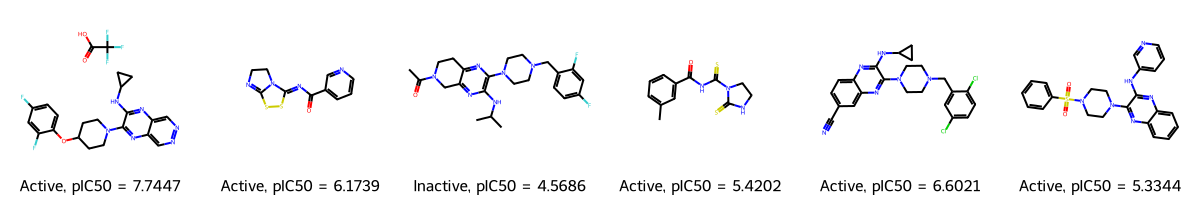

In [194]:
Draw.MolsToGridImage(
    [compounds_morgan_structure["Structure"][clusters[i][0]] for i in range(6)],
    molsPerRow=6,
    legends=[
        f"{compounds_morgan_structure['bioactivity'][clusters[i][0]]}, pIC50 = {compounds_morgan_structure['pIC50'][clusters[i][0]]:.4f}"
        for i in range(6)]
)